In [57]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
import shap
from ultralytics import YOLO
import random
import cv2

import tensorflow as tf

### Step 1: Random image selection from test dataset

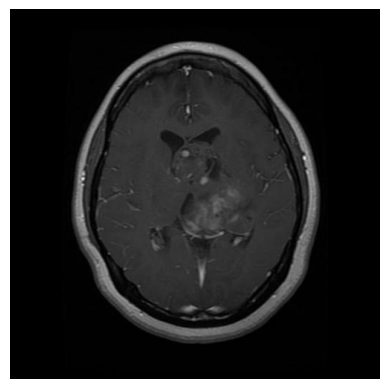

Image Name: Tr-gl_0381_jpg.rf.9389dcdc94c61b058b96aff07e6fecbb.jpg
Class Prefix: gl
Tumor Class: Glioma


In [58]:
test_image_dir = "Labeled-MRI-Brain-Tumor-Dataset-1/test/images"

image_files = os.listdir(test_image_dir)

random_image = random.choice(image_files)


# Plot selected random image
random_image_path = os.path.join(test_image_dir, random_image)

image = Image.open(random_image_path)
plt.imshow(image)
plt.axis("off")
plt.show()




# Retrieve original label from images'name

class_mapping = {
    "gl": "Glioma",
    "me": "Meningioma",
    "no": "No Tumor",
    "pi": "Pituitary"
}

prefix = random_image.split('-')[1].split('_')[0]
tumor_class = class_mapping.get(prefix, "Unknown")

print(f"Image Name: {random_image}")
print(f"Class Prefix: {prefix}")
print(f"Tumor Class: {tumor_class}")

### Step 2: Use random image file as the input of CNN model to predict its class

In [59]:
# Preprocess the selected image for the CNN model
image_size = (128, 128)
image = image.resize(image_size)
image_array = np.array(image) / 255.0
image_array = np.expand_dims(image_array, axis=0)

In [61]:
# Load the Pre-trained CNN Model ---
cnn_checkpoint_dir = './checkpoints'
cnn_model_path = os.path.join(cnn_checkpoint_dir, 'cnn_model.keras')
cnn_model = tf.keras.models.load_model(cnn_model_path)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step


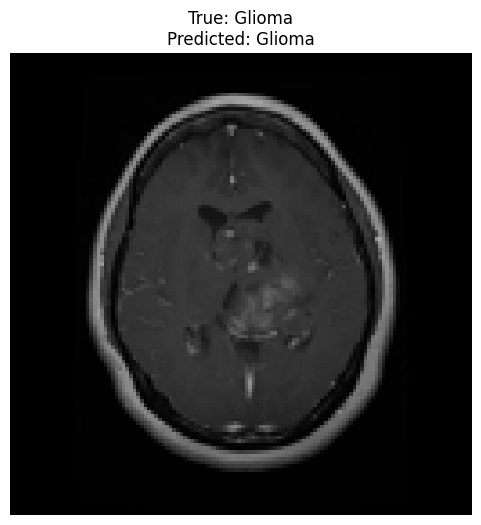

Random Image: Tr-gl_0381_jpg.rf.9389dcdc94c61b058b96aff07e6fecbb.jpg
True Class: Glioma
Predicted Class: Glioma
Confidence: 1.00
Accuracy Metric: 1.00


In [62]:
# Make a prediction using the CNN model
prediction = cnn_model.predict(image_array)
predicted_class_index = np.argmax(prediction)
predicted_class = list(class_mapping.values())[predicted_class_index]

# Retrieve the true class index
true_class_index = list(class_mapping.keys()).index(prefix)

# Use Keras metrics to calculate accuracy
accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
true_class_tensor = tf.constant([true_class_index])
predicted_probs_tensor = tf.constant(prediction)

# Update and compute accuracy
accuracy_metric.update_state(true_class_tensor, predicted_probs_tensor)
accuracy = accuracy_metric.result().numpy()

# Display the results
plt.figure(figsize=(6, 6))
plt.imshow(image)
plt.axis("off")
plt.title(f"True: {tumor_class}\nPredicted: {predicted_class}")
plt.show()

# Print prediction result
print(f"Random Image: {random_image}")
print(f"True Class: {tumor_class}")
print(f"Predicted Class: {predicted_class}")
print(f"Confidence: {prediction[0][predicted_class_index]:.2f}")
print(f"Accuracy Metric: {accuracy:.2f}")

### Step 3: Use ExplainableAI to justify

In [63]:
import shap

shap.initjs();

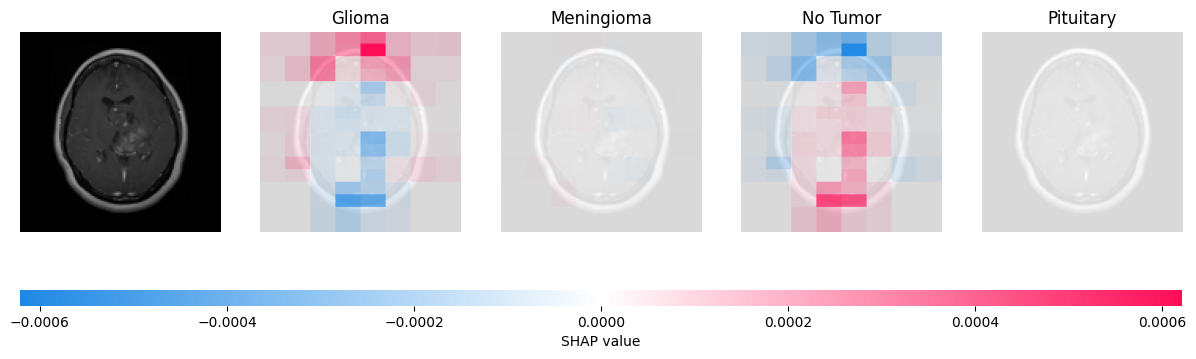

In [64]:
# Assume image_array is already prepared, and cnn_model is loaded

# Define the masker (masking partitions of the input image)
masker = shap.maskers.Image("blur(128,128)", image_array.shape[1:])  # image_array[0].shape gives (128, 128, 3)

# Initialize the SHAP Explainer with the model and the masker
explainer = shap.Explainer(cnn_model, masker, output_names=list(class_mapping.values()))

# Compute SHAP values for the image
shap_values = explainer(image_array)  # No need for batch_size and outputs here

# Visualize the SHAP explanation for the image
shap.image_plot(shap_values, image_array)

### Step 4: Detect the tumor location

In [65]:
# --- Step 2: Load the Pre-trained YOLOv8 Model and Dataset ---
yolo_checkpoint_dir = './checkpoints'
yolo_model_path = os.path.join(yolo_checkpoint_dir, 'yolo8_model.pt')
yolo_model = YOLO(yolo_model_path)

In [66]:
yolo_model.save('yolo_model.h5')
print("Model saved as 'yolo_model.h5'")

Model saved as 'yolo_model.h5'


In [67]:
import joblib

In [68]:
joblib.dump(cnn_model, 'yolo_model.pkl')

['yolo_model.pkl']

In [69]:

yolo_model.save('yolo_model.keras')
print("Model saved as 'yolo_model.keras'")

Model saved as 'yolo_model.keras'


image 1/1 /home/gokhan/code/joelbrice/brainmap/notebooks/Labeled-MRI-Brain-Tumor-Dataset-1/test/images/Tr-gl_0381_jpg.rf.9389dcdc94c61b058b96aff07e6fecbb.jpg: 640x640 1 Glioma, 164.9ms
Speed: 2.9ms preprocess, 164.9ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)


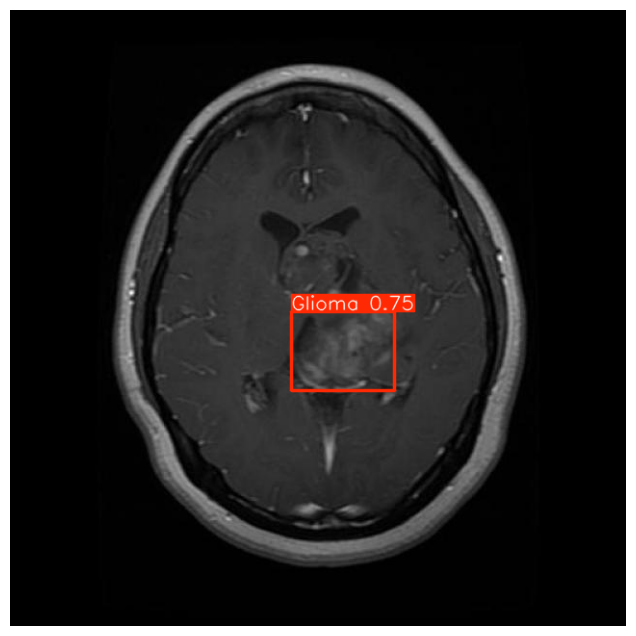

In [70]:
tumor_detection= yolo_model.predict(source=random_image_path)

predicted_image = tumor_detection[0].plot()

plt.figure(figsize=(8, 8))
plt.imshow(predicted_image)
plt.axis('off')
plt.show()

In [55]:
def predict(image_path):
    """
    Predicts tumor type and location from an input image using both CNN and YOLO models.
    Displays SHAP explanations and tumor detection results.

    Args:
    - image_path (str): Path to the input image.
    """
    # --- Step 1: Prepare Class Mapping ---
    class_mapping = {
        "gl": "Glioma",
        "me": "Meningioma",
        "no": "No Tumor",
        "pi": "Pituitary"
    }



    image = Image.open(image_path).convert('RGB')

    # we should call "preprocessor" function instead of following code
    image_size = (128, 128)
    image_resized = image.resize(image_size)
    image_array = np.array(image_resized) / 255.0
    image_array = np.expand_dims(image_array, axis=0)

    # We should call "load_model" function to load the model from a folder
    cnn_checkpoint_dir = './model_folder'
    cnn_model_path = os.path.join(cnn_checkpoint_dir, 'cnn_model.pkl')
    cnn_model = load_model(cnn_model_path)

    # Make a prediction using the CNN model
    prediction = cnn_model.predict(image_array)
    predicted_class_index = np.argmax(prediction)
    predicted_class = list(class_mapping.values())[predicted_class_index]

    # Compute accuracy metric
    true_class_index = list(class_mapping.keys()).index(prefix)
    accuracy_metric = tf.keras.metrics.SparseCategoricalAccuracy()
    true_class_tensor = tf.constant([true_class_index])
    predicted_probs_tensor = tf.constant(prediction)
    accuracy_metric.update_state(true_class_tensor, predicted_probs_tensor)
    accuracy = accuracy_metric.result().numpy()

    # Display CNN Prediction Results
    plt.figure(figsize=(6, 6))
    plt.imshow(image_resized)
    plt.axis("off")
    plt.title(f"True: {tumor_class}\nPredicted: {predicted_class}\nConfidence: {prediction[0][predicted_class_index]:.2f}")
    plt.show()

    print(f"Prediction Results:")
    print(f"True Class: {tumor_class}")
    print(f"Predicted Class: {predicted_class}")
    print(f"Confidence: {prediction[0][predicted_class_index]:.2f}")
    print(f"Accuracy Metric: {accuracy:.2f}")

    # --- Step 4: SHAP Explanation ---
    shap.initjs()
    masker = shap.maskers.Image("blur(128,128)", image_array.shape[1:])
    explainer = shap.Explainer(cnn_model, masker, output_names=list(class_mapping.values()))
    shap_values = explainer(image_array)

    # Visualize SHAP Explanations
    shap.image_plot(shap_values, image_array)

    # We should call "load_model" function to load the model from a folder
    yolo_checkpoint_dir = './checkpoints'
    yolo_model_path = os.path.join(yolo_checkpoint_dir, 'yolo8_model.pt')
    yolo_model = YOLO(yolo_model_path)

    # Make a prediction using the YOLO model
    tumor_detection = yolo_model.predict(source=image_path)
    predicted_image = tumor_detection[0].plot()

    # Display YOLO Detection Results
    plt.figure(figsize=(8, 8))
    plt.imshow(predicted_image)
    plt.axis('off')
    plt.title("YOLO Tumor Detection")
    plt.show()

In [56]:
predict(random_image_path)

Image Name: Tr-no_0466_jpg.rf.abeeb51c69ba93bf3e6f6844dd4155df.jpg
Class Prefix: no
Tumor Class: No Tumor


NameError: name 'load_model' is not defined